In [253]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from numpy.linalg import eig
import os
from GeneralizedProcrustes import GeneralizedProcrustes
from scipy.linalg import svd

In [254]:
df = pd.DataFrame([], columns=['Patient','Landmark','X','Y'])
fileCount = 0
for file in os.listdir('Data'):
    data = np.loadtxt('Data/'+file, delimiter=',', skiprows=1)
    tmp = pd.DataFrame(data, columns=['Landmark', 'X', 'Y'])
    tmp['Patient'] = file
    df = pd.concat((df,tmp))
    fileCount +=1

df = df.loc[(df.Landmark != 9) & (df.Landmark != 18)]
df.to_csv('Landmark.csv')

In [255]:
shapeList = []
for patient in np.unique(df.Patient.values):
    shape = df.loc[df.Patient==patient, ['X','Y']].to_numpy()
    shapeList.append(shape)

newShapes = GeneralizedProcrustes(shapeList, maxIter=5)

Distance between mean shape and reference shape dist=2.7975181299443865.
Distance between mean shape and reference shape dist=0.9503140472600102.
Distance between mean shape and reference shape dist=0.9503140472600102.
Distance between mean shape and reference shape dist=0.9503140472600101.
Distance between mean shape and reference shape dist=0.9503140472600102.


In [256]:
df = pd.DataFrame([], columns=['Shape', 'Landmark', 'X', 'Y'])
for i, shape in enumerate(newShapes):
    tmp = pd.DataFrame(np.zeros((shape.shape[0],4)), columns=['Shape', 'Landmark', 'X', 'Y'])
    tmp['X'] = shape[:,0]
    tmp['Y'] = shape[:,1]
    tmp.Shape = i+1
    tmp.Landmark = np.arange(1, shape.shape[0]+1)
    df = pd.concat((df, tmp))
df = df.set_index(['Shape', 'Landmark'])
df.to_csv('Landmarks_Aligned.csv')
df

X         Y
Shape Landmark                    
1     1         -0.21858 -0.029845
      2         -0.20143 -0.074973
      3        -0.142946 -0.152504
      4        -0.107302 -0.204665
      5         -0.02084 -0.231378
...                  ...       ...
12    12       -0.034327  0.174976
      13        0.015917  0.196622
      14        0.105621  0.214101
      15        0.168285   0.26345
      16        0.257767   0.23695

[192 rows x 2 columns]

In [257]:
df = pd.read_csv('Landmarks_Aligned.csv', index_col=(0,1))
shapes = df.index.get_level_values('Shape').drop_duplicates()
n = shapes.size
data = np.zeros((2*df.index.get_level_values('Landmark').drop_duplicates().size, n))
for i, shape in enumerate(shapes):
    landmarks = df.loc[shape].values[:,:].ravel().T
    data[:,i] = landmarks   
print(data.shape)

(32, 12)


In [258]:
pca = PCA(whiten=True)
pca.fit(data.T)
cov = pca.get_covariance()
eigva, eigve = eig(cov)
P = np.real(eigve).T
print(f'Real part {np.linalg.norm(P)} vs imaginary part {np.linalg.norm(np.imag(eigve))}')
stds = np.sqrt(np.abs(eigva))

Real part 5.31853794548832 vs imaginary part 1.9269546238562247


In [259]:
meanShape = np.zeros((data.shape[0],))
m,N = data.shape
for i in range(N):
    meanShape += data[:,i]
meanShape /= N
meanShape = meanShape.reshape((meanShape.shape[0],1))

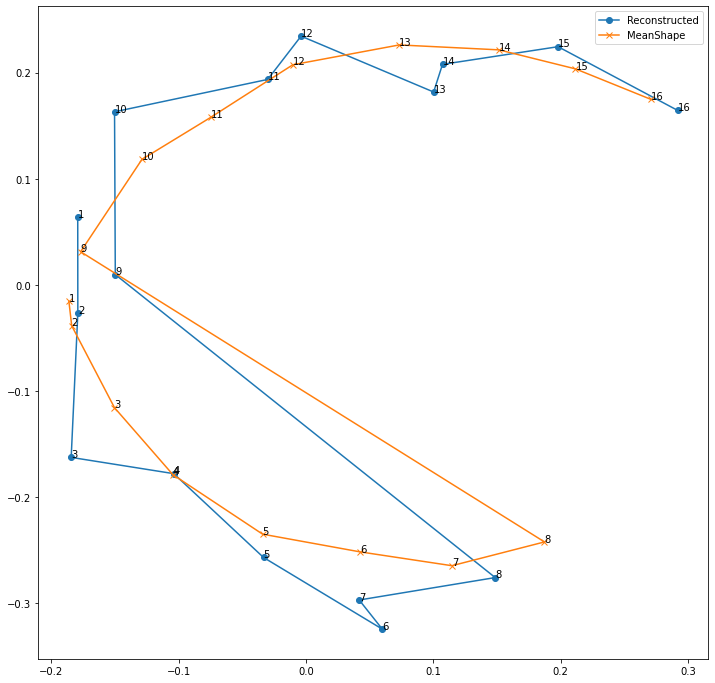

In [260]:
b = np.random.normal(0.0, stds*10)
xn = meanShape[:,0] + P.dot(b)
x,y = xn[::2], xn[1::2]
fig, ax = plt.subplots(figsize=(12,12))
# ax.set_xlim((-0.5,0.5))
# ax.set_ylim((-0.5,0.5))
ax.plot(x,y, label='Reconstructed', marker='o')
xmean, ymean = meanShape[::2], meanShape[1::2]
ax.plot(xmean,ymean, label='MeanShape', marker='x')

for i in range(x.size):
    ax.annotate(i+1, (x[i],y[i]))
    ax.annotate(i+1, (xmean[i],ymean[i]))   

plt.legend()

In [261]:
W = (data-meanShape.dot(np.ones((1,N))))/(np.sqrt(N-1))
U,s,V = svd(W.T, full_matrices=True)
print(U.shape, s.shape, V.shape)
print(s)

(12, 12) (12,) (32, 32)
[1.09399044e-01 9.77287890e-02 7.49606812e-02 6.69582652e-02
 5.49670478e-02 4.80301794e-02 3.80899671e-02 3.66868967e-02
 2.94288348e-02 2.26694488e-02 1.89152204e-02 9.49803492e-17]


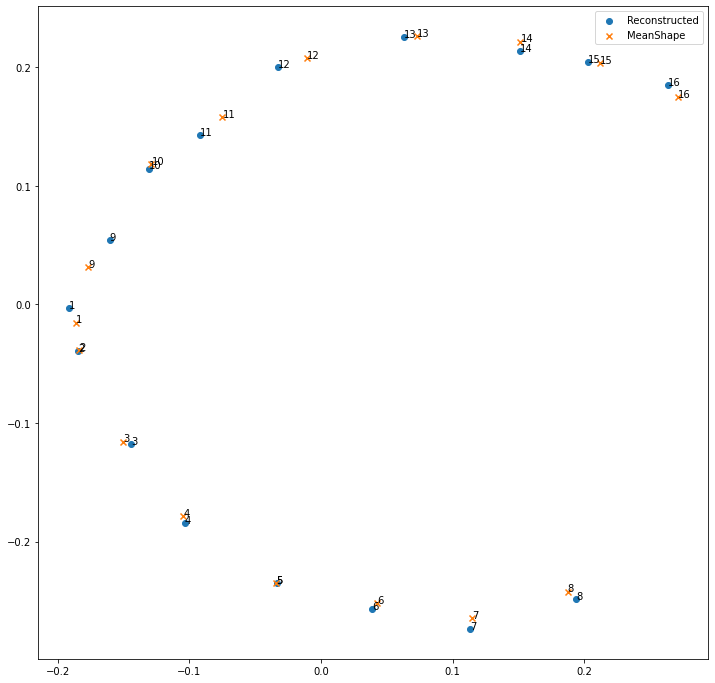

In [262]:
p = V.shape[0]
b = np.random.normal(0.0, scale=3*stds)
xn = meanShape[:,0] + V.dot(b)
x,y = xn[::2], xn[1::2]

fig, ax = plt.subplots(figsize=(12,12))
# ax.set_xlim((-0.5,0.5))
# ax.set_ylim((-0.5,0.5))
ax.scatter(x,y, label='Reconstructed')
xmean, ymean = meanShape[::2], meanShape[1::2]
ax.scatter(xmean,ymean, label='MeanShape', marker='x')

for i in range(x.size):
    ax.annotate(i+1, (x[i],y[i]))
    ax.annotate(i+1, (xmean[i],ymean[i]))   

plt.legend()